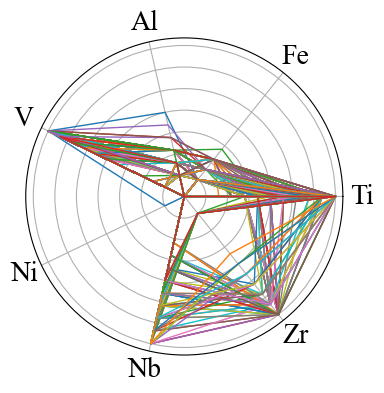

In [1]:
#Note: This code is used to plot Figure 5(b-d) of the manscuript.

import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import time
import numpy as np
import torch
from torch import nn, optim, autograd
from math import pi
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import torch.nn.functional as F


torch.manual_seed(123456)
np.random.seed(123456)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


class Unit3(nn.Module):
    def __init__(self, in_N, out_N,actf):
        super(Unit3, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.actf = actf
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        actf=self.actf
        x1 = self.L(x)
        if actf==0:
            x2 = torch.tanh(x1)
        elif actf==1:
            x2 = torch.sigmoid(x1) 
        elif actf==2:
            x2 = torch.relu(x1)
        elif actf==3:
            x2 = torch.selu(x1)
        elif actf==4:
            x2 = F.softmax(x1, dim=1)
        return x2
    
class NN3(nn.Module):
    def __init__(self, in_N, width1, depth1,width2, depth2,out_N,bn,dp,dprate,actf):
        super(NN3, self).__init__()
        self.width1 = width1
        self.width2 = width2
        self.depth1 = depth1
        self.depth2 = depth2
        self.bn = bn
        self.dp = dp
        self.dprate = dprate
        self.actf = actf
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()
        self.stack.append(Unit3(in_N, width1[0],actf))
        if bn==1:
            self.stack.append(nn.BatchNorm1d(width1[0]))
        for i in range(1,depth1):
            self.stack.append(Unit3(width1[i-1], width1[i],actf))
        
        if dp==1:
            self.stack.append(nn.Dropout(p=dprate))
        if depth2==1:
            self.stack.append(Unit3(width1[i], width2[0],1)) 
        else:
            self.stack.append(Unit3(width1[i], width2[0],actf))    
            for i in range(1,depth2-1):
                self.stack.append(Unit3(width2[i-1], width2[i],actf))
            self.stack.append(Unit3(width2[depth2-2], width2[depth2-1],4)) 
            
    def forward(self, x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

activation=0
dropout=1
dropout_rate=0.29791
normalization=1
batch_size=1000
layers1=10
layers2=1
neurons=86
learning_rate=0.00065
L1=[neurons]*layers1
L2=[neurons]*layers2+[8]
model_h = NN3(35,L1,layers1,L2,layers2+1, 8,normalization,dropout,dropout_rate,0)


        
load=1
PATH="checkpoint/model-1406.pt"
if load==1:
    checkpoint = torch.load(PATH)
    model_h.load_state_dict(checkpoint['model_h_state_dict'])
    optimizer2 = optim.AdamW([{'params': model_h.parameters()}], lr=learning_rate) 
    optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])

import numpy as np
norm=np.load('norm.npy')[0]
norm[10,1]=1
norm[11,1]=1
norm[12,1]=1
norm[13,1]=1
norm[14,1]=1
norm[15,1]=1

Temp=850 #temperature
A = np.loadtxt(f'Labels_7el_d=0.03_{Temp}K_extra.txt')[:, 10:]
comp=np.loadtxt(f'Labels_7el_d=0.03_{Temp}K_extra.txt')[:,1:8]
a=Temp*np.ones([A.shape[0],1])
A=np.append(A,a,axis=1)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i,j]=(A[i,j]-norm[j][0])/(norm[j][1]-norm[j][0])
        
n=[7,9,38,40,45,48,49,39,25,26,29,47,34,35,41,46]
A1=np.delete(A,n,axis=1)
model_h.eval()
xlo_test=A1
y = model_h(torch.from_numpy(xlo_test).float())
n=np.zeros([0,7])
for i in range(y.shape[0]):
    a=y[i,0]+y[i,2]+y[i,3]+y[i,4]+y[i,5]+y[i,6]+y[i,7]
    if a<0.10: #threshold of phase
        n=np.append(n,comp[[i],:],axis=0)
import matplotlib.pyplot as plt
import numpy as np

num_labels = 7
num_points = n.shape[0]
data = np.copy(n) 
angles = np.linspace(0, 2 * np.pi, num_labels, endpoint=False).tolist()
data = np.concatenate((data, data[:,[0]]), axis=1)
angles += angles[:1]
labels = ['Ti', 'Fe', 'Al', 'V', 'Ni', 'Nb', 'Zr']
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(polar=True))
plt.tight_layout()

for i in range(num_points):
    ax.plot(angles, data[i], linewidth=1, linestyle='solid', label=f'Data Point {i+1}')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels,fontsize=20, fontname='Times New Roman')
ax.set_yticklabels([])
ax.yaxis.set_tick_params(labelsize=0) 

plt.savefig('figure.png', dpi=600)

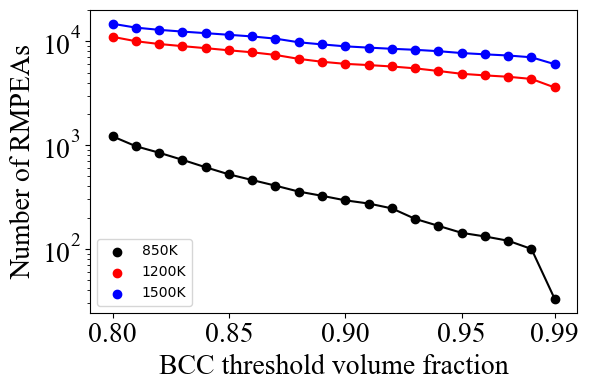

In [5]:
#Note: This code plots Figure 5(a) of the manscuript

import numpy as np
import matplotlib.pyplot as plt
nx1=[0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.84,0.83,0.82,0.81,0.80]
ny1=[33, 100, 120, 132, 143, 167, 195, 246, 274, 294, 325, 357, 407, 461, 523, 612, 722, 845, 976, 1215]

nx2=[0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.84,0.83,0.82,0.81,0.80]
ny2=[3590, 4339, 4554, 4695, 4863, 5178, 5489, 5719, 5903, 6063, 6351, 6771, 7389, 7833, 8188, 8586, 8980, 9417, 10017, 11042]

nx3=[0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.84,0.83,0.82,0.81,0.80]
ny3=[6018, 7013, 7297, 7488, 7705, 8030, 8280, 8468, 8692, 8941, 9333, 9783, 10606, 11132, 11548, 11977, 12402, 12892, 13544, 14751]

plt.figure(figsize=(6, 4))     

plt.scatter(nx1,ny1,color='black')
plt.scatter(nx2,ny2,color='red')
plt.scatter(nx3,ny3,color='blue')
plt.plot(nx1,ny1,color='black')
plt.plot(nx2,ny2,color='red')
plt.plot(nx3,ny3,color='blue')
plt.legend(['850K','1200K','1500K'])
plt.yscale('log')
plt.xticks([0.99,0.95,0.90,0.85,0.80])
plt.xlabel('BCC threshold volume fraction',fontsize=20, fontname='Times New Roman') #Absolute deviation tolerance per phase
plt.ylabel('Number of RMPEAs',fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=20, fontname='Times New Roman')
plt.yticks(fontsize=20, fontname='Times New Roman') #[0.2,0.4,0.6,0.8,1],
plt.tight_layout()
plt.savefig('figure.png', dpi=600)

In [6]:
#Note: the data used in the earlier part is generated with this code

import torch
cols = [0,2,3,4,5,6,7]
a = y[:, cols].sum(dim=1)            
m_tensor = torch.tensor([0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]) 
counts = (a.unsqueeze(1) < m_tensor).sum(dim=0)  
P = counts.tolist()
print(P)

[33, 100, 120, 132, 143, 167, 195, 246, 274, 294, 325, 357, 407, 461, 523, 612, 722, 845, 976, 1215]
